In [1]:
import os
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [3]:
import math
import time
import numpy as np
from copy import deepcopy
import pickle
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.nn import functional as F
from torch.utils.data import Subset
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches


from data import get_othello, plot_probs, plot_mentals
from data.othello import permit, start_hands, OthelloBoardState, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbeIA
from mingpt.utils import sample, intervene, print_board
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

plt.rcParams.update(plt.rcParamsDefault)
# plt.rc('text', usetex=True)
# plt.rc('font', **{'size': 14.0})
# plt.rc('text.latex', preamble=r'\usepackage{lmodern}')

In [4]:
championship = False

In [5]:
mid_dim = 128
how_many_history_step_to_use = 99
exp = f"state_tl{mid_dim}"
if championship:
    exp += "_championship"

## Load a game from intervention benchmark and select an intervention configuration

In [6]:
with open("intervention_benchmark.pkl", "rb") as input_file:
    dataset = pickle.load(input_file)

In [7]:
case_id = 888
wtd = {
    "intervention_position": permit_reverse(dataset[case_id]["pos_int"]), 
    "intervention_from": dataset[case_id]["ori_color"], 
    "intervention_to": 2 - dataset[case_id]["ori_color"], 
}
completion = dataset[case_id]["history"]
print(wtd)
print(completion)
print(dataset[case_id])
ab = OthelloBoardState()
ab.update(completion, prt=True)

pre_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
print("valid moves:", pre_intv_valids)

{'intervention_position': 'd6', 'intervention_from': 0.0, 'intervention_to': 2.0}
[44, 29, 18, 26, 19, 43, 45, 11, 42, 37, 34, 41, 25, 52, 53, 51, 59, 60]
{'history': [44, 29, 18, 26, 19, 43, 45, 11, 42, 37, 34, 41, 25, 52, 53, 51, 59, 60], 'pos_int': 29, 'ori_color': 0.0}
--------------------
[]
a                
b                
c                
d       O X      
e       X O      
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['f5']
a                
b                
c                
d       O X      
e       X X      
f         X      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['f5', 'd6']
a                
b                
c                
d       O O O    
e       X X      
f         X      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['f5', 'd6', 'c3']
a                
b                
c     X        

In [8]:
wtd_list = [wtd]



## Load nonlinear probe at layer 8

In [9]:
# probes = {}
# layer_s = 4
# layer_e = 9
# for layer in range(layer_s, layer_e):
#     p = BatteryProbeClassificationTwoLayer(torch.cuda.current_device(), probe_class=3, num_task=64, mid_dim=mid_dim)
#     load_res = p.load_state_dict(torch.load(f"./ckpts/battery_othello/{exp}/layer{layer}/checkpoint.ckpt"))
#     p.eval()
#     probes[layer] = p

championship = False
mid_dim = 256
how_many_history_step_to_use = 99
exp = f"state_tl{mid_dim}"
if championship:
    exp += "_championship"

device = torch.device('cpu')
#device = torch.cuda.current_device()
probes = {}
layer = 8
probe = BatteryProbeClassificationTwoLayer(device, probe_class=3, num_task=64, mid_dim=mid_dim)
load_res = probe.load_state_dict(torch.load(f"./ckpts/battery_othello/{exp}/layer{layer}/checkpoint.ckpt", map_location=device))
probe.eval()

BatteryProbeClassificationTwoLayer(
  (proj): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=192, bias=True)
  )
)

## Load trained models for probing at layer 8

In [10]:
# # othello = get_othello(ood_perc=.2, data_root="data/othello_pgn", wthor=False)
# othello = get_othello(ood_perc=0., data_root=None, wthor=False, ood_num=1)
# train_dataset = CharDataset(othello)

# mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)

# models = {}
# for layer in range(layer_s, layer_e):
#     model = GPTforProbeIA(mconf, probe_layer=layer)
#     # model = GPT(mconf)
#     load_res = model.load_state_dict(torch.load("./ckpts/gpt_synthetic.ckpt" if not championship else "./ckpts/gpt_championship.ckpt"))
#     if torch.cuda.is_available():
#         device = torch.cuda.current_device()
#         model = model.to(device)
#     _ = model.eval()
#     models[layer] = model

othello = get_othello(ood_perc=0., data_root=None, wthor=False, ood_num=1)
train_dataset = CharDataset(othello)

mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)

model = GPTforProbeIA(mconf, probe_layer=layer)#, disable_last_layer_norm = True
load_res = model.load_state_dict(torch.load("./ckpts/gpt_synthetic.ckpt", map_location=device))
# if torch.cuda.is_available():
#     device = torch.cuda.current_device()
#     model = model.to(device)
model.eval()

100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Dataset created has 1 sequences, 61 unique words.


GPTforProbeIA(
  (tok_emb): Embedding(61, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elem

### Check the partial game progression

In [11]:
ab = OthelloBoardState()
ab.update(completion, prt=True)
pre_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
print("valid moves:", pre_intv_valids)

--------------------
[]
a                
b                
c                
d       O X      
e       X O      
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['f5']
a                
b                
c                
d       O X      
e       X X      
f         X      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['f5', 'd6']
a                
b                
c                
d       O O O    
e       X X      
f         X      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['f5', 'd6', 'c3']
a                
b                
c     X          
d       X O O    
e       X X      
f         X      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['f5', 'd6', 'c3', 'd3']
a                
b                
c     X          
d     O O O O    
e       X X      
f     

In [30]:
partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)
partial_game = partial_game[None, :]
#h = model.forward_1st_stage(partial_game)
h = query_in.unsqueeze(0).unsqueeze(0)
print(h.shape)

#head is just a weight linear 512 by 61 as seen in model.py, call this weight W
#call the last row in h, embedding_input, just a vector of size 512
#Vary each value in the embedding_vector upto 0.01% of its current value. Called the result vector embedding_p
#then embedding_p*W is a vector of size 61
#check that embedding_input*W and embedding_p*W decoded to the same set of next legal move
#do this on MARABOU

#TODO find output vector mapping to human readable output (training data label)
out1 = model.head(model.ln_f(h))
print("output by running head(h):\n", out1[0][-1][:], out1.shape)

out2, _ = model(partial_game)
print("output by running the model(s):\n", out2[0][-1][:], out2.shape)

reconstructed_board, _ = probe((h)[0][-1])
print("reconstructed board:\n", reconstructed_board.squeeze()[:10])

def probe_result_to_board(reconstructed_board):
    board = torch.argmax(reconstructed_board.squeeze(), dim = -1).reshape(64).tolist()
    return board
board = probe_result_to_board(reconstructed_board)
print(board)



torch.Size([1, 1, 512])
output by running head(h):
 tensor([-4.1270, -1.7884, -3.1603, -3.4044,  0.2054,  7.7045, -1.5154, -2.2303,
        -1.9694, -1.9216, -2.9282, -2.2161, -1.7640,  8.3813, -1.2772, -1.9708,
        -3.5504, -1.8465, -1.9058, -2.0219, -2.5852,  7.9284,  8.7078, -1.8156,
        -2.6662, -2.1273, -2.3679, -2.6379, -1.9707,  8.4220, -2.3595, -1.6798,
        -2.1879, -1.8827, -2.3600,  8.5775, -2.2795,  8.4838, -1.3604, -1.4601,
        -1.8487, -2.6073, -2.1934, -2.8010, -2.7223,  8.5726, -0.7084,  8.5866,
        -2.4120, -2.3385, -2.3194, -0.6794, -2.6685, -2.1176, -1.7623,  0.2711,
        -1.6847, -1.8320,  8.6094, -1.4780, -1.8585], grad_fn=<SliceBackward0>) torch.Size([1, 1, 61])
output by running the model(s):
 tensor([-5.2589, -2.0611, -2.8018, -3.0063,  7.7758,  7.8361, -1.6718, -2.3594,
        -2.6148, -2.2483, -2.5150, -2.5595, -1.9102,  7.7744, -1.5704, -2.2384,
        -3.5364, -2.2118, -2.2511, -1.9897, -2.8324,  7.7565,  7.8481, -1.6253,
        -2.7

|        |
|   O    |
|  XO    |
| XXOOO  |
|  XOOO  |
| OXOOX  |
|   OOX  |
|   XO   |
[[False False False  True  True False False False]
 [False False False False  True False False False]
 [False False False False  True  True False False]
 [False False False False False False  True False]
 [False False False False False False  True False]
 [ True False False False False False False False]
 [ True False  True False False False False False]
 [False False False False False  True False False]]
valid moves: ['a4', 'a5', 'b5', 'c5', 'c6', 'd7', 'e7', 'f1', 'g1', 'g3', 'h6']
--------------------
['f5', 'd6', 'c3', 'd3', 'c4', 'f4', 'f6', 'b4', 'f3', 'e6', 'e3', 'f2', 'd2', 'g5', 'g6', 'g4', 'h4', 'h5']
a                
b       O        
c     X O        
d   X X O O O    
e     X O O O    
f   O X O O X    
g       O O X    
h       X O      
  1 2 3 4 5 6 7 8
--------------------
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0,

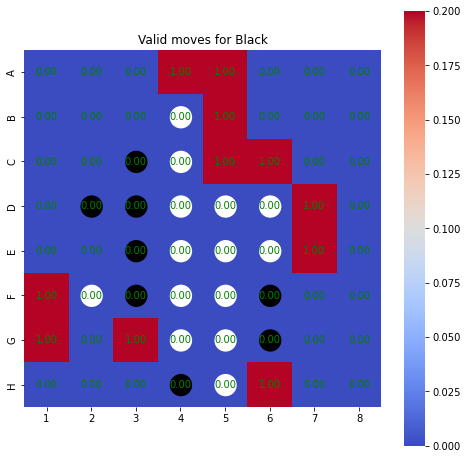

In [33]:
#printing out probed board
for i in range(8):
    print("|", end='')
    for j in range(8):
        c = board[i*8+j]
        if c == 1:
            print(" ", end='')
        elif c==0:
            print("O", end='')
        elif c==2:
            print("X", end='')
    print("|\n", end='')

#turning model output, out1 or out2 both the same, into human readable valid moves output
valid_moveset = out2[0, -1, 1:]
padding = torch.zeros(2)
valid_moveset = torch.softmax(valid_moveset, dim=0)
valid_moveset = torch.cat([valid_moveset[:27], padding, valid_moveset[27:33], padding, valid_moveset[33:]], dim=0)
valid_moveset = valid_moveset.detach().cpu().numpy().reshape(8, 8)
valid_moveset = valid_moveset > np.mean(valid_moveset)
print(valid_moveset)
vv = 0.2
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
#fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(valid_moveset, vmin=0., vmax=vv, 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f", ax=ax, cmap=sns.color_palette("coolwarm", as_cmap=True),annot_kws={'color':'green'})
color = {-1:'white', 0:'grey', 1:'black'}
ann_col = [color[i] for i in ab.state.flatten().tolist()]
patchList = []
for loca, col in enumerate(ann_col):
    if col != 'grey':
        patchList.append(PatchCollection([mpatches.Circle((loca%8 + 0.5, loca//8 + 0.5) ,.25, facecolor=col)], match_original=True))
for i in patchList:
    ax.add_collection(i)
next_color = ab.get_next_hand_color() 
text_for_next_color = color[next_color * 2 -1].capitalize()
ax.set_title(f"Valid moves for {text_for_next_color}")

print("valid moves:", pre_intv_valids)

#printing out official board
official_board = ab.get_state()
ab.__print__()

official_board = ab.get_state()
print(official_board)
for i in range(8):
    print("|", end='')
    for j in range(8):
        c = official_board[i*8+j]
        if c == 1:
            print(" ", end='')
        elif c==0:
            print("O", end='')
        elif c==2:
            print("X", end='')
    print("|\n", end='')

print("probed board compared with official board:",board == official_board)

def get_valid_moveset(vm_list):
    moveset = np.zeros((8,8))
    for move in vm_list:
        r, c = move // 8, move % 8
        moveset[r][c] = 1
    return moveset

official_valids = get_valid_moveset(ab.get_valid_moves())
print(official_valids)
print("Model valid moveset compared with official valid moveset:", np.array_equal(official_valids, valid_moveset))

### Marabou Experiments

In [20]:
from maraboupy import Marabou, MarabouCore
from maraboupy.MarabouNetwork import MarabouNetwork
import tempfile
def build_marabou_net(nnet, dummy_input: torch.Tensor):
    """
        convert the network to MarabouNetwork
    """
    nnet.eval()
    tempf = tempfile.NamedTemporaryFile(delete=False)
    torch.onnx.export(nnet, dummy_input, tempf.name, verbose=False)

    marabou_net = Marabou.read_onnx(tempf.name)
    #fw_ipq = MarabouCore.InputQuery(marabou_net.getForwardQuery())
    return marabou_net#, fw_ipq

mnet = build_marabou_net(model.head, model.ln_f(h[0][-1][:]))
default_input = model.ln_f(h[0][-1][:]).detach().numpy()
default_output = out1[0][-1][:].detach().numpy()
#print(model.head.weight.shape)
print(type(mnet))
print(len(mnet.inputVars[0]))  #512 input vars
input_vars = mnet.inputVars[0]
print(len(mnet.outputVars[0])) #61 output vars
output_vars = mnet.outputVars[0]
perturb = 0.5
for i in range(len(default_input)):
    mnet.setLowerBound(input_vars[i], default_input[i]-perturb)
    mnet.setUpperBound(input_vars[i], default_input[i]+perturb)
for i in range(len(default_output)):
    if default_output[i] >= 0:
        mnet.setLowerBound(output_vars[i], 0)
    else:
        mnet.setUpperBound(output_vars[i], 0)
mnet.setUpperBound(output_vars[4], 0)
mnet.setLowerBound(output_vars[4], -100)
#mnet.saveQuery("headQuery.txt")
query_solved = mnet.solve(verbose=False)

#TODO
#do same with probe, flip one ouput (black to white, put new piece on board)
#cleanup, package code into functions, with documentation
#gradient ascent? 


<class 'maraboupy.MarabouNetworkONNX.MarabouNetworkONNX'>
512
61
Engine::processInputQuery: Input query (before preprocessing): 61 equations, 573 variables
Engine::processInputQuery: Input query (after preprocessing): 61 equations, 573 variables

Input bounds:
	x0: [ -3.3802,  -2.3802] 
	x1: [ -2.1683,  -1.1683] 
	x2: [ -0.2989,   0.7011] 
	x3: [  2.9515,   3.9515] 
	x4: [  0.4124,   1.4124] 
	x5: [ -1.7538,  -0.7538] 
	x6: [ -2.7970,  -1.7970] 
	x7: [  3.3148,   4.3148] 
	x8: [ -1.3350,  -0.3350] 
	x9: [ -1.6134,  -0.6134] 
	x10: [ -1.9122,  -0.9122] 
	x11: [ -0.5782,   0.4218] 
	x12: [  1.6159,   2.6159] 
	x13: [ -1.3054,  -0.3054] 
	x14: [  1.5337,   2.5337] 
	x15: [ -0.0622,   0.9378] 
	x16: [ -3.0232,  -2.0232] 
	x17: [ -0.2921,   0.7079] 
	x18: [  2.5901,   3.5901] 
	x19: [  3.1179,   4.1179] 
	x20: [ -1.0692,  -0.0692] 
	x21: [  0.6835,   1.6835] 
	x22: [  0.8802,   1.8802] 
	x23: [ -1.9290,  -0.9290] 
	x24: [ -0.9278,   0.0722] 
	x25: [ -1.9756,  -0.9756] 
	x26: [  3.6809,   4.

In [24]:
print(query_solved[1])
query_in = []
for i in range(0, 512):
    query_in.append(query_solved[1][i])
query_in = torch.tensor(query_in)
print(query_in)


{0: -2.3802034854888916, 1: -2.1682779788970947, 2: -0.2988925874233246, 3: 2.951469659805298, 4: 0.41236305236816406, 5: -1.7538151741027832, 6: -1.7969982624053955, 7: 3.314756155014038, 8: -1.3349934816360474, 9: -0.6134467124938965, 10: -1.9121943712234497, 11: 0.42178797721862793, 12: 1.6158747673034668, 13: -0.30540794134140015, 14: 1.5337092876434326, 15: -0.062225013971328735, 16: -3.023226022720337, 17: -0.2921315133571625, 18: 2.590108871459961, 19: 3.1178832054138184, 20: -0.06921416521072388, 21: 0.6834988594055176, 22: 1.8801811933517456, 23: -1.9290285110473633, 24: 0.07219526171684265, 25: -0.9756462574005127, 26: 3.6809353828430176, 27: -2.8617286682128906, 28: -0.862561821937561, 29: -0.896903783082962, 30: 3.6029129028320312, 31: 0.27869683504104614, 32: -0.7633698582649231, 33: -1.4769813418388367, 34: 0.7096903324127197, 35: -0.7198482751846313, 36: 0.6692163944244385, 37: -0.8790503144264221, 38: 1.1901217103004456, 39: -0.48430925607681274, 40: 0.745603084564209, 

### Check pre-intervention ground-truth legal next-steps and the predicted ones

In [ ]:
pre_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
pre_intv_valids

['b4', 'c6', 'd3', 'e7', 'f4', 'f6']

In [ ]:
pre_intv_pred, _ = model(partial_game[None, :])  # [B, T, F=512]
# no history activations used here, that's why the prediction map is different to across layers
pre_intv_pred = pre_intv_pred[0, -1, 1:]
padding = torch.zeros(2).cuda()
pre_intv_pred = torch.softmax(pre_intv_pred, dim=0)
pre_intv_pred = torch.cat([pre_intv_pred[:27], padding, pre_intv_pred[27:33], padding, pre_intv_pred[33:]], dim=0)

<AxesSubplot:>

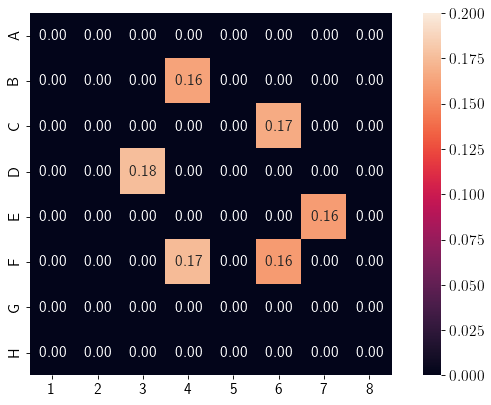

In [ ]:
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
vv = 0.2
sns.heatmap(pre_intv_pred.detach().cpu().numpy().reshape(8, 8), vmin=0., vmax=vv, 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

## Check post-intervention ground-truth next steps
0 for white; 1 for blank; 2 for black

In [ ]:
htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
for wtd in wtd_list:
    move = permit(wtd["intervention_position"])
    r, c = move // 8, move % 8
    ab.state[r, c] = wtd["intervention_to"] - 1
ab.__print__()
post_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
post_intv_valids

--------------------
['e6', 'd6', 'c3', 'f3', 'c4']
a                
b                
c     X X        
d       X X O    
e       O X O    
f     O          
g                
h                
  1 2 3 4 5 6 7 8
--------------------


['b3', 'b4', 'c6', 'd3', 'f4']

## Intervene and observe how the world representation changes along the way

e6 Sucessfully intervened!
e6 Sucessfully intervened!
e6 Sucessfully intervened!
e6 Sucessfully intervened!
e6 Sucessfully intervened!


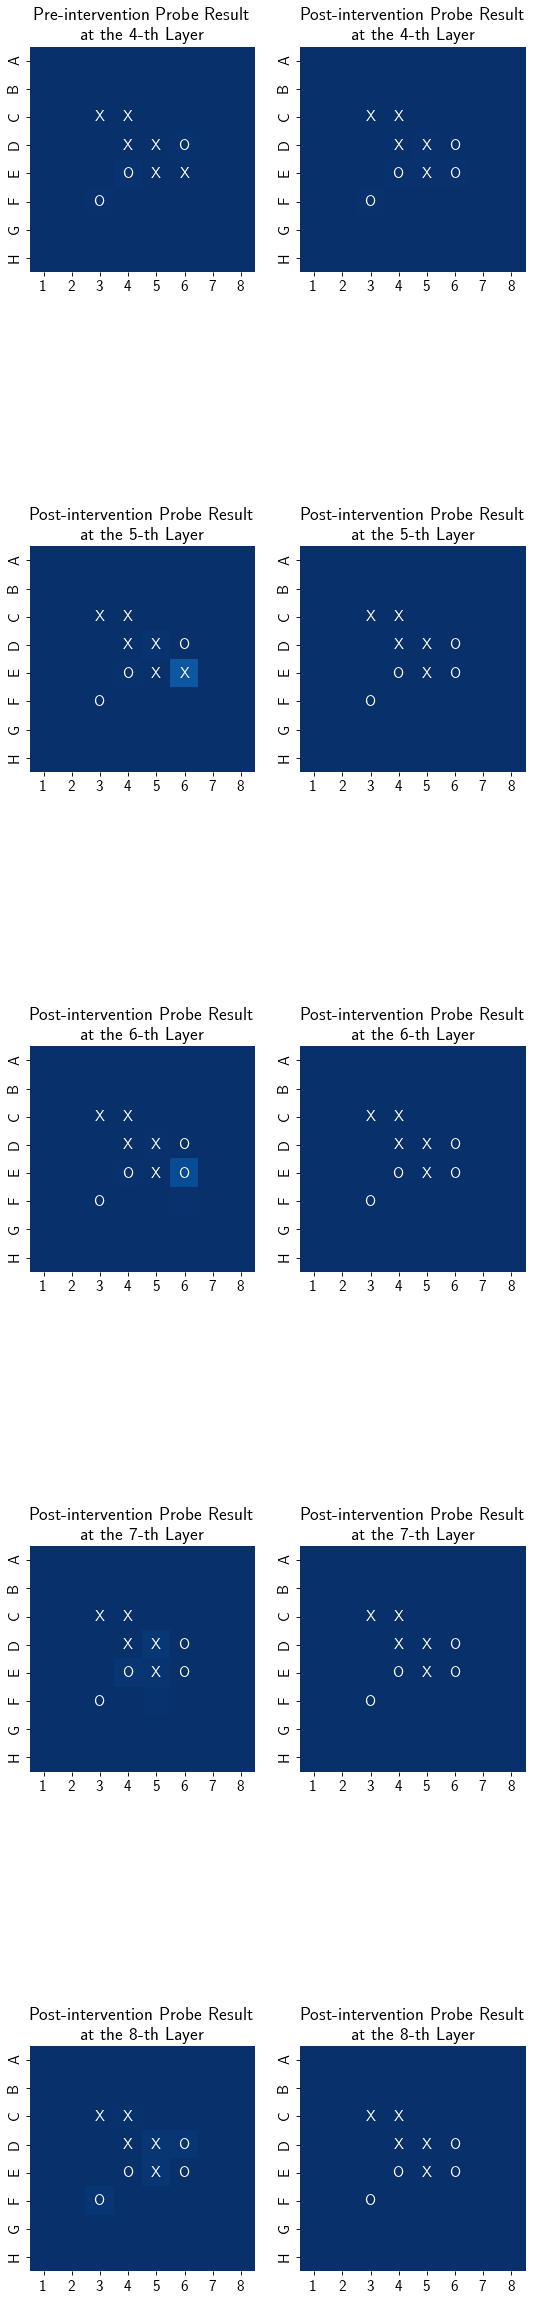

In [ ]:
fig, axs = plt.subplots(layer_e - layer_s, 2, figsize=(8 * (1), 8 * (layer_e - layer_s)), dpi= 80, facecolor='w', edgecolor='k')
# two rows for the intervened layer layer_s, one for the rest
if len(axs.shape) == 1:
    axs = axs[:, None]

p = probes[layer_s]
whole_mid_act = models[layer_s].forward_1st_stage(partial_game[None, :])  # [B, T, F=512]

# intervene at the earlest interested layer 
mid_act = whole_mid_act[0, -1]
pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
plot_mentals(axs[0, 0], pre_intv_logits)
axs[0, 0].set_title(f"Pre-intervention Probe Result \n at the {layer_s}-th Layer")
labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
new_mid_act = mid_act.clone()
for wtd in wtd_list:
    new_mid_act = intervene(p, new_mid_act, labels_pre_intv, wtd, htd, plot=True)
    pre_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
plot_mentals(axs[0, 1], post_intv_logits)
axs[0, 1].set_title(f"Post-intervention Probe Result \n at the {layer_s}-th Layer")
# swap in 
whole_mid_act[0, -1] = new_mid_act

for i, layer in enumerate(range(layer_s, layer_e - 1)):  # 4, 5, 6, 7, indices of the layers to be passed
    p = probes[layer+1]
    whole_mid_act = models[layer_s].forward_2nd_stage(whole_mid_act, layer, layer+1)[0]  # [1, T, F=512]
    
    # intervene the output of the features freshly out
    mid_act = whole_mid_act[0, -1]
    pre_intv_logits = p(mid_act[None, :])[0].squeeze(0)  # [64, 3]
    plot_mentals(axs[i+1, 0], pre_intv_logits)
    axs[i+1, 0].set_title(f"Post-intervention Probe Result \n at the {layer+1}-th Layer")
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    new_mid_act = mid_act.clone()
    for wtd in wtd_list:
        new_mid_act = intervene(p, new_mid_act, labels_pre_intv, wtd, htd, plot=True)
        pre_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
        labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    post_intv_logits = p(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
    plot_mentals(axs[i+1, 1], post_intv_logits)
    axs[i+1, 1].set_title(f"Post-intervention Probe Result \n at the {layer+1}-th Layer")
    # swap in 
    whole_mid_act[0, -1] = new_mid_act

## Compare post-intervention prediction heatmap with pre-intervention ones
Underscored tiles are the ground-truth

Text(0.5, 1.0, 'Post-intervention Prediction Heatmap')

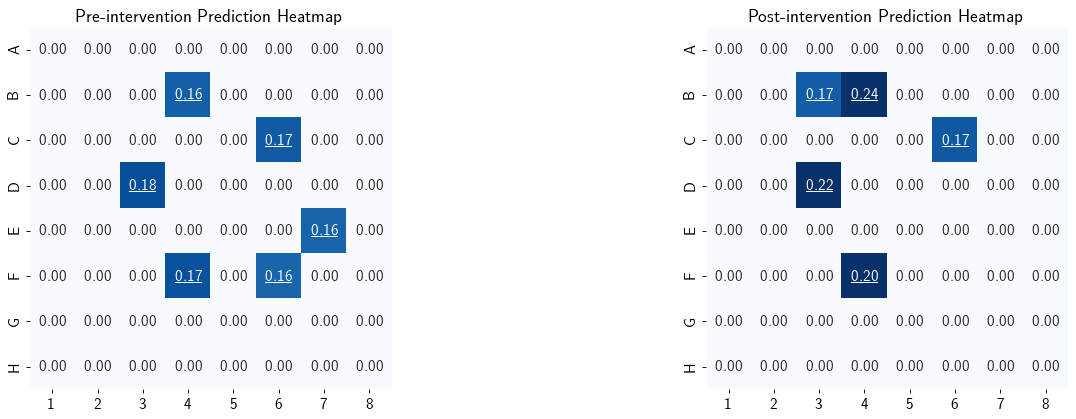

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), dpi= 80, facecolor='w', edgecolor='k')

plot_probs(axs[0], pre_intv_pred, [permit(_) for _ in pre_intv_valids])
axs[0].set_title(f"Pre-intervention Prediction Heatmap")

tb_resumed = whole_mid_act
post_intv_pred, _ = models[layer_s].predict(tb_resumed)
post_intv_pred = post_intv_pred[0, -1, 1:]
post_intv_pred = torch.softmax(post_intv_pred, dim=0)
post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)

plot_probs(axs[1], post_intv_pred, [permit(_) for _ in post_intv_valids])
axs[1].set_title(f"Post-intervention Prediction Heatmap")